229


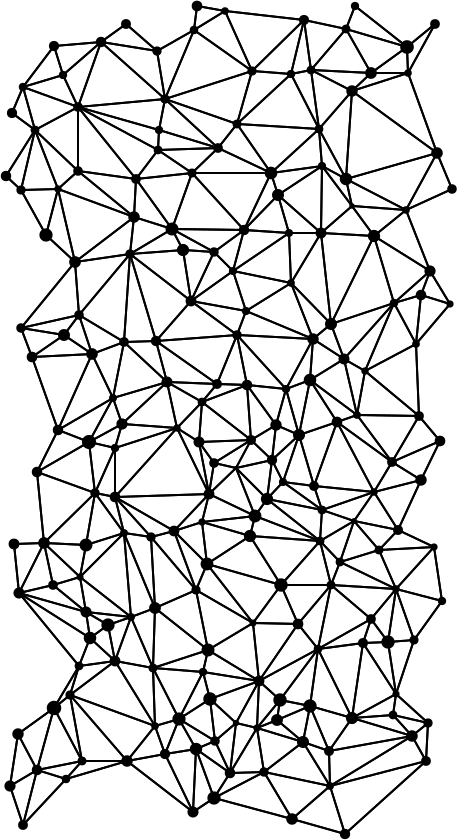

In [77]:
import math as m
import contextlib
import io
import cairo
import IPython.display
import attr

WIDTH  = 460  # mm 
HEIGHT = 840  # mm

@contextlib.contextmanager
def showctx(width=WIDTH, height=HEIGHT, scale=0.5):
    svgio = io.BytesIO()
    with cairo.SVGSurface(svgio, scale*WIDTH, scale*HEIGHT) as surface: 
        ctx = cairo.Context(surface)
        ctx.scale(scale, scale)
        yield ctx
    IPython.display.display(IPython.display.SVG(data=svgio.getvalue()))

@attr.s(frozen=True)
class Node:
    x = attr.ib()
    y = attr.ib()
    r = attr.ib(default=5)
#     links = attr.ib(factory=list)
    
    def draw(self, ctx):
        ctx.arc(self.x, self.y, self.r, 0, 2*m.pi)
        ctx.fill()
        
    def in_view(self, left, top, right, bottom):
        return (self.x - self.r >= left  and
                self.x + self.r <= right and
                self.y - self.r >= top   and
                self.y + self.r <= bottom)
    
@attr.s(frozen=True)
class Link:
    a = attr.ib()
    b = attr.ib()
    
    def draw(self, ctx):
        ctx.move_to(self.a.x, self.a.y)
        ctx.line_to(self.b.x, self.b.y)
        ctx.stroke()
        
    @property
    def dist(self):
        return abs(self.b.x + 1j*self.b.y - self.a.x - 1j*self.a.y)

import numpy as np
from scipy.spatial import Delaunay

def mklinks(nodes):
    points = np.array([[n.x, n.y] for n in nodes])
    for a,b,c in Delaunay(points).simplices:
        yield Link(nodes[a], nodes[b])
        yield Link(nodes[b], nodes[c])
        yield Link(nodes[c], nodes[a])

import random
random.seed(47)
EPSILON=20
nodes = [Node(random.randint(-30, WIDTH+30), random.randint(-30, HEIGHT+30), random.gauss(5, 1))
         for _ in range(400)]
links = list(mklinks(nodes))
for link in links:
    if link.dist < EPSILON:
        try:
            nodes.remove(min(link.a, link.b))
        except ValueError:  # we'd removed it before, whatever
            pass

# recompute with pruned nodes
print(len(nodes))
links = list(mklinks(nodes))

# remove nodes and links that go out of the picture
nodes = [n for n in nodes if n.in_view(0, 0, WIDTH, HEIGHT)]
links = [c for c in links if c.a.in_view(0, 0, WIDTH, HEIGHT) and c.b.in_view(0, 0, WIDTH, HEIGHT)]

with showctx(scale=1) as ctx:
    ctx.set_line_width(2)
    for obj in nodes + links: obj.draw(ctx)        